# Maximum Possible Return on Equity

__Objective:__  
What is the maximum possible return that could be achieved trading NASDAQ and NYSE historical stocks from 02/01/2000 to 27/08/2024?

## Conditions
1. Long only
2. Look-ahead bias
3. Diversification - hold 20 positions, each representing ~5% of portfolio (no other forms of diversification).
4. 100% invested, always
5. Trading Fees
6. Slippage
7. Holding period of at least 1 bar with no maximum period
8. Assume position can be liquidated at close of bar and new position opened at open of next bar
9. Equity must have sufficient transaction volume at the time of purchase such that a $5000 purchase is <= 10% of the volume at a given interval.  For example, a $1 equity would require 5000 shares to form a $5000 position.  The equity must have a minimum volume of 5000/0.1 = 50000 shares.

## Source
https://www.kaggle.com/datasets/sbgonenc96/2000-2024-stocks-data

## Reference
https://www.kaggle.com/code/sbgonenc96/stocks-timeanalysis

In [61]:
import pandas as pd
import json
import pathlib
import matplotlib.pyplot as plt

In [3]:
import tqdm

In [4]:
import kagglehub

c:\users\user\onedrive\stocks\research & reference\nb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Download latest version
path = kagglehub.dataset_download("sbgonenc96/2000-2024-stocks-data")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844M/844M [01:21<00:00, 10.8MB/s]

Extracting files...


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\sbgonenc96\2000-2024-stocks-data\versions\36


In [32]:
dir_data = pathlib.Path(path)
assert dir_data.is_dir()

In [36]:
files_json = [list(f_.glob('*.json')) for f_ in dir_data.glob('*')]
files_json = [x for xs in files_json for x in xs]
assert files_json[-1].is_file()
files_json[:3]

[WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/A.json/A_merged.json'),
 WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/B.json/B_merged.json'),
 WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/C.json/C_merged.json')]

In [44]:
# read a single file
with open(files_json[-1], "r") as f:
    data_json = json.load(f)
type(data_json)

list

In [106]:
data_json[0].keys()

dict_keys(['ticker', 'queryCount', 'resultsCount', 'adjusted', 'results', 'status', 'request_id', 'count'])

In [108]:
ticker = data_json[0]['ticker']
col_rename = columns = {"c" : "close", "h":"high", "l": "low", "n":"n_transactions",
                        "o": "open", "t":"time", "v":"volume", "vw":"vwap"}
cols_use = ['volume', 'vwap', 'open', 'close', 'time']
df = pd.DataFrame.from_dict(data_json[0]['results']).rename(columns=col_rename)[cols_use]
df

,volume,vwap,open,close,time
0,9547333,0.0001,0.000100,0.000200,1661866200000
1,5000000,0.0002,0.000200,0.000200,1661875200000
2,3820000,0.0001,0.000100,0.000200,1661887800000
3,350000,0.0002,0.000200,0.000200,1661954400000
4,700000,0.0001,0.000100,0.000200,1661959800000
...,...,...,...,...,...
869,5000000,NaN,0.000001,0.000001,1723559400000
870,4686,NaN,0.000001,0.000001,1724160600000
871,900,0.0001,0.000050,0.000050,1724344200000
872,1000000,0.0001,0.000050,0.000050,1724427000000


In [109]:
df["time"] = pd.to_datetime(df["time"], unit="ms")
df = df.set_index("time")
df

,volume,vwap,open,close
time,,,,
2022-08-30 13:30:00,9547333,0.0001,0.000100,0.000200
2022-08-30 16:00:00,5000000,0.0002,0.000200,0.000200
2022-08-30 19:30:00,3820000,0.0001,0.000100,0.000200
2022-08-31 14:00:00,350000,0.0002,0.000200,0.000200
2022-08-31 15:30:00,700000,0.0001,0.000100,0.000200
...,...,...,...,...
2024-08-13 14:30:00,5000000,NaN,0.000001,0.000001
2024-08-20 13:30:00,4686,NaN,0.000001,0.000001
2024-08-22 16:30:00,900,0.0001,0.000050,0.000050


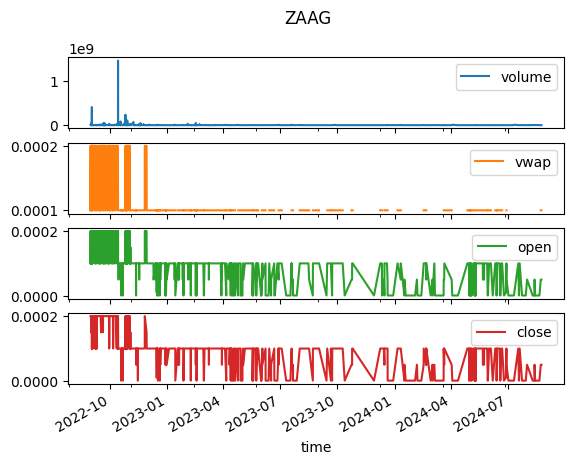

In [111]:
df.select_dtypes(exclude=[object]).plot(subplots=True, title=ticker)
plt.show()

## Efficiency
What is the most effective way to load all data?

## Methodology
Filter to equities that meet minimum volume criteria.  Identify the top 30 positive percent change values for every interval measured from the 'open' to the 'close'.  Provide ordered list of ticker symbols for each interval, sorted descending by percent change.

### Position Logic
1. Are there equities for whom the return for the next interval is greater thana position with a higher return 

In [112]:
equity_starting = 100000
size_position_pct = 0.05
size_position = equity_starting * size_position_pct
position_max_pct_of_volume = 0.1
min_ticker_dollar_volume = size_position / position_max_pct_of_volume
min_ticker_dollar_volume

50000.0

In [114]:
df['has_min_volume'] = df['volume'] * df['vwap'] > min_ticker_dollar_volume
df['has_min_volume'] = df['has_min_volume'].astype(bool)

In [115]:
df.drop(columns = ['volume', 'vwap'], inplace=True)

In [116]:
df[['open', 'close', 'has_min_volume']]

,open,close,has_min_volume
time,,,
2022-08-30 13:30:00,0.000100,0.000200,False
2022-08-30 16:00:00,0.000200,0.000200,False
2022-08-30 19:30:00,0.000100,0.000200,False
2022-08-31 14:00:00,0.000200,0.000200,False
2022-08-31 15:30:00,0.000100,0.000200,False
...,...,...,...
2024-08-13 14:30:00,0.000001,0.000001,False
2024-08-20 13:30:00,0.000001,0.000001,False
2024-08-22 16:30:00,0.000050,0.000050,False


In [117]:
df['has_min_volume'].value_counts()

has_min_volume
False    872
True       2
Name: count, dtype: int64

In [118]:
df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]

time
2022-10-13 18:00:00   -0.510000
2022-10-13 18:30:00    0.020408
Name: close, dtype: float64

In [119]:
dfs = {}
dfs[ticker] = df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]

In [120]:
dfs[ticker]

time
2022-10-13 18:00:00   -0.510000
2022-10-13 18:30:00    0.020408
Name: close, dtype: float64

## Make Functions

### Parameters

In [112]:
equity_starting = 100000
size_position_pct = 0.05
size_position = equity_starting * size_position_pct
position_max_pct_of_volume = 0.1
min_ticker_dollar_volume = size_position / position_max_pct_of_volume
min_ticker_dollar_volume

50000.0

In [142]:
col_rename = columns = {"c" : "close", "h":"high", "l": "low", "n":"n_transactions",
                                "o": "open", "t":"time", "v":"volume", "vw":"vwap"}
cols_use = ['volume', 'vwap', 'open', 'close', 'time']
cols_required = set(['c', 'o', 't', 'v', 'vw'])
cols_checks = ['has_required_cols', 'has_min_volume', 'has_qualified_records']
quality_checks = {}
dfs = {}
# has_required_cols = {}
file_json_ = files_json[-1]

In [136]:
len(cols_required.difference(json_['results'][0].keys()))

1

In [124]:
def read_json(file):
    # read a single file
    with open(file, "r") as f:
        data_json = json.load(f)
    return data_json
    del data_json

In [132]:
json_['results'][0].keys()

dict_keys(['v', 'o', 'c', 'h', 'l', 't', 'n', 'otc'])

In [143]:
cols_checks

['has_required_cols', 'has_min_volume', 'has_qualified_records']

In [147]:
# %%time
for file_json_ in files_json[:2]:
    list_of_jsons = read_json(file_json_)
    for json_ in list_of_jsons:
        checks_ = []
        ticker = json_['ticker']
        print(ticker)
        has_required_cols_ = len(cols_required.difference(json_['results'][0].keys())) == 0
        checks_.append(has_required_cols_)
#         has_vwap[ticker] = has_required_cols_
        if not has_required_cols_:
            pass
        elif has_required_cols_:
            df = pd.DataFrame.from_dict(json_['results']).rename(columns=col_rename)[cols_use]
            df["time"] = pd.to_datetime(df["time"], unit="ms")
            df = df.set_index("time")
            df['has_min_volume'] = df['volume'] * df['vwap'] > min_ticker_dollar_volume
            df['has_min_volume'] = df['has_min_volume'].astype(int)
            checks_.append(df['has_min_volume'].mean())
            has_qualified_records_ = df['has_min_volume'].eq(1).any()
            checks_.append(has_qualified_records_)
            if has_qualified_records_:
                df.drop(columns = ['volume', 'vwap'], inplace=True)
        #         df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]
                dfs[ticker] = df.loc[df['has_min_volume'].astype(bool), ['open', 'close']]\
                                .pct_change(axis=1).iloc[:,-1]
            elif not has_qualified_records_:
                pass
        quality_checks[ticker] = checks_

AAALY
AABB
AABVF
AACAF
AACAY
AACG
AAC
AACI
AACIU
AACIW
AACS
AACTF
AACT
AADI
AAEEF
AAFRF
AAGC
AAGFF
AAGH
AAGIY
AAGR
AAGRW
AAGRY
AA
AAIC
AAIGF
AAIIQ
AAIN
AAIRF
AALBF
AAL
AAMAF
AAMC
AAME
AAMMF
AAMTF
AAN
AANNF
AAOI
AAON
AAP
AAPJ
AAPL
AAPT
AAQC
AAQCW
AARTY
AASP
AASZF
AATC
AATGF
AAT
AATP
AATV
AAUGF
AAU
AAUKF
AAVMY
AAVVF
AAVXF
AAWH
AAWW
AAXT
AAYYY
ABANF
ABAT
ABBB
ABB
ABBNY
ABBRF
ABBV
ABBY
ABCAF
ABCB
ABCE
ABCFF
ABC
ABCL
ABCM
ABCP
ABCZF
ABDBY
ABEO
ABEPF
ABEV
ABG
ABGI
ABGOF
ABGSF
ABHBY
AB
ABILF
ABIO
ABIT
ABLE
ABL
ABLLL
ABLLW
ABLT
ABLV
ABLVW
ABLZF
ABMBF
ABMC
ABMD
ABM
ABML
ABMRF
ABMT
ABNAF
ABNB
ABOIF
ABOS
ABPPF
ABPR
ABQQ
ABR
ABRMF
ABSCF
ABSI
ABSOF
ABSSF
ABST
ABT
ABTI
ABTO
ABTS
ABTX
ABTZY
ABUS
ABVC
ABVE
ABVEW
ABVG
ABVN
ABVX
ABWN
ABXXF
ABZPF
ABZPY
ABZT
ABZUF
ACAB
ACABU
ACABW
ACAC
ACACU
ACACW
ACAD
ACAH
ACA
ACAHU
ACAHW
ACAI
ACAN
ACAQ
ACAVF
ACAX
ACAXR
ACAXU
ACAXW
ACAZF
ACBA
ACBAU
ACBAW
ACBCQ
ACBD
ACB
ACBM
ACCA
ACCD
ACCFF
ACCMF
ACCO
ACCR
ACCYY
ACDC
ACDCW
ACDI
ACDVF
ACEEU
ACEHF
ACEJF
ACEL
ACENY
ACER
ACET

ASBRF
ASCA
ASCAR
ASCAU
ASCAW
ASCB
ASCBR
ASCBU
ASCBW
ASCCF
ASCC
ASCCY
ASC
ASCJF
ASCK
ASCLF
ASCN
ASCS
ASCUF
ASDN
ASDRF
ASDZF
ASEJF
ASEKF
ASEKY
ASEPF
ASFH
ASFT
ASFX
ASG
ASGLF
ASGLY
ASGN
ASGOF
ASGRF
ASGTF
ASGXF
ASH
ASHI
AS
ASHTF
ASHTY
ASHXF
ASII
ASIX
ASKE
ASKH
ASLE
ASLM
ASLN
ASLRF
ASMB
ASM
ASMIY
ASMLF
ASML
ASMMF
ASMVF
ASMVY
ASMXF
ASNB
ASNCF
ASND
ASNS
ASNXF
ASO
ASOMF
ASOMY
ASOZF
ASOZY
ASPA
ASPAU
ASPAW
ASPCF
ASPD
ASPHF
ASPI
ASPN
ASPR
ASPS
ASPT
ASPU
ASPW
ASPZ
ASRE
ASR
ASRMF
ASRT
ASRV
ASSF
ASST
ASTA
ASTC
ASTE
ASTGY
ASTH
ASTI
ASTL
ASTLW
ASTO
ASTR
ASTS
ASTSW
ASTTF
ASTVF
ASUR
ASUUY
ASWRF
ASXC
ASXFF
ASXFY
ASX
ASXSF
ASYS
ASZ
ATAAY
ATADF
ATA
ATAI
ATAK
ATAKR
ATAKU
ATAKW
ATAO
ATAQF
ATAQ
ATAR
ATASF
ATASY
ATAT
ATAX
ATAZF
ATBHF
ATBPF
ATCC
ATCD
ATCH
ATCHW
ATCLF
ATCMF
ATCN
ATCO
ATCOL
ATCUF
ATCV
ATCX
ATDEF
ATDRF
ATDRY
ATDS
ATEAY
ATEC
ATEK
ATEN
ATEPF
ATER
ATEX
ATEYY
ATGE
ATGFF
ATGGF
ATGL
ATGN
ATGSF
ATGSY
ATGVF
ATHA
ATHC
ATHE
ATHHF
ATHJF
ATHLL
ATHLV
ATHM
ATHOF
ATHX
ATIF
ATIG
ATI
ATIP
ATIW
ATIXF
ATKR
ATLC
ATLC

BTCM
BTCS
BTCT
BTCTW
BTCWF
BTCY
BTDG
BTDPF
BTDPY
BTDR
BTEAF
BTEGF
BTE
BTGGF
BTGHF
BTG
BTGN
BTGOF
BTGRF
BTI
BTIM
BTKRD
BTKRF
BTLCY
BTLLF
BTMD
BTMDW
BTM
BTMWW
BTN
BTNY
BTOC
BTOG
BTOOY
BTOW
BTQNF
BTRCF
BTRMF
BTRS
BTRYF
BTSDF
BTSG
BTSGU
BTSGY
BTSR
BTTC
BTTR
BTTX
BTU
BTUMF
BTURF
BTVCF
BTVCY
BTVRF
BTWN
BTWNU
BTWNW
BTX
BTZI
BUBSF
BUDFF
BUD
BUDZ
BUENF
BUGDF
BUGLF
BUGVF
BUHF
BUHPF
BUJA
BUJAR
BUJAW
BUKS
BULT
BUNM
BURBY
BURCA
BURCB
BURCF
BUR
BURL
BURUD
BURU
BUSC
BUSE
BUUZ
BVAXF
BVDRF
BVERS
BVFL
BVHBB
BVH
BV
BVHMF
BVILF
BVILY
BVLDF
BVN
BVNKF
BVNNF
BVNRY
BVRDF
BVSFF
BVS
BVTEF
BVTK
BVVBY
BVXV
BWAC
BWACU
BWACW
BWAGF
BWA
BWAQ
BWAQR
BWAQU
BWAQW
BWAV
BWAY
BWBBP
BWB
BWCAU
BWCAW
BWCGF
BWC
BWEFF
BWEL
BWEN
BWFG
BW
BWIN
BWLKF
BWLLF
BWLLY
BWLP
BWLVF
BWMG
BWMN
BWMX
BWMY
BWNAF
BWNB
BWOWF
BWPC
BWSN
BWTL
BWTX
BWV
BWVI
BWXT
BXBLY
BXC
BXDIF
BX
BXLC
BXMT
BXNG
BXPHF
BXP
BXRBF
BXRDF
BXRX
BXRXQ
BXXRF
BXXY
BYAGF
BYCBF
BYCRF
BYDC
BYDDF
BYDDY
BYDGF
BYD
BYDIF
BYDIY
BYDMF
BYFC
BYFMF
BYHFF
BY
BYLB
BYLG
BYLOF
BYLTF
BYMOF
BYND

In [153]:
df_checks = pd.DataFrame.from_dict(quality_checks, orient='index', columns=cols_checks)
df_checks.mean()

has_required_cols         0.95935
has_min_volume           0.215663
has_qualified_records    0.661959
dtype: object

In [156]:
%%timeit
pd.DataFrame.from_dict(dfs)

1.96 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
%%timeit
pd.concat(dfs, axis=1)

1.75 s ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [158]:
df = pd.DataFrame.from_dict(dfs)

In [164]:
df.head().max(axis=1)

time
2022-08-29 08:00:00    0.015002
2022-08-29 08:30:00    0.004435
2022-08-29 09:00:00    0.004469
2022-08-29 09:30:00    0.001562
2022-08-29 10:00:00    0.002235
dtype: float64

<Axes: xlabel='time'>

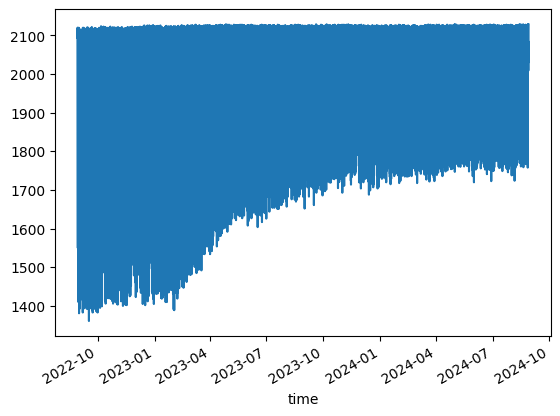

In [166]:
df.isna().sum(axis=1).plot()